In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from ipywidgets import interact, FloatSlider
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

In [2]:
file_path = os.getcwd() + '/flow_data/beech/downstairs_zone/hall_sensor_2024-07-11_00-38-51.csv'
df = pd.read_csv(file_path, names=['pi_timestamps', 'timestamps'])
df['frequency'] = 1 / (df['timestamps'].diff().shift(-1)) * 1e9
display(df)

,pi_timestamps,timestamps,frequency
0,1.720655e+09,1609468155866447000,33.788350
1,1.720655e+09,1609468155896043000,33.443698
2,1.720655e+09,1609468155925944000,33.700671
3,1.720655e+09,1609468155955617000,33.670034
4,1.720655e+09,1609468155985317000,33.922453
...,...,...,...
299415,1.720662e+09,1609475585285704000,33.682509
299416,1.720662e+09,1609475585315393000,33.997416
299417,1.720662e+09,1609475585344807000,33.790633
299418,1.720662e+09,1609475585374401000,33.647376


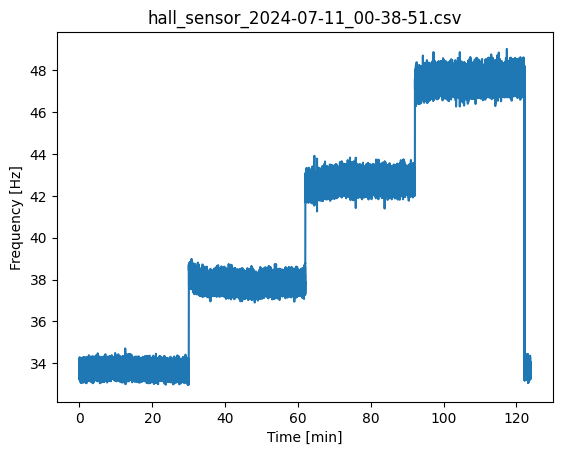

In [3]:
time_minutes = (df['timestamps']-df.timestamps[0])/1e9/60
plt.plot(time_minutes, df.frequency)
plt.title(file_path.split('/')[-1])
plt.xlabel('Time [min]')
plt.ylabel('Frequency [Hz]')
plt.show()

In [4]:
def get_df(first_point, last_point):
    return df[int(first_point):int(last_point)]

def lowpass_filter(df, f_c, f_s):
    b, a = butter(N=5, Wn=f_c, fs=f_s, btype='low', analog=False)
    return filtfilt(b, a, df)

def plot_interactive(alpha, f_c, first_point, last_point):

    df = get_df(first_point, last_point)

    # Low pass filter
    f_s = 4*max(df.frequency)
    timestamps, values = list(df.timestamps), list(df.frequency)
    new_timestamps = np.linspace(min(timestamps), max(timestamps), int((max(timestamps)-min(timestamps))/1e9 * f_s))
    interp_func = interp1d(timestamps, values, kind='linear')
    interpolated_values = interp_func(new_timestamps)
    filtered = lowpass_filter(interpolated_values, f_c, f_s)

    # Exponential weighted average
    W = [0]*len(values)
    theta = list(values)
    for t in range(len(values)-1):
        W[t+1] = alpha*W[t] + (1-alpha)*theta[t+1]

    # Convert time to seconds since first tick
    timestamps_sec = [(x-timestamps[0])/1e9 for x in timestamps]
    new_timestamps_sec = [(x-timestamps[0])/1e9 for x in new_timestamps]

    plt.figure(figsize=(12,6))
    plt.plot(timestamps_sec[200:], values[200:], alpha=0.3, label=f'Original signal', color='tab:gray')
    plt.plot(timestamps_sec[200:], W[200:], alpha=0.7, label=f'Exponential weighted average', color='tab:blue')
    plt.plot(new_timestamps_sec[1000:], filtered[1000:], alpha=0.7, label=f'Low pass filter', color='tab:orange')
    plt.xlabel('Time [seconds]')
    plt.ylabel('Frequency [Hz]')
    plt.legend()
    plt.show()
    
alpha_slider = FloatSlider(min=0.5, max=1, step=0.001, value=0.7, description='Alpha')
cutoff_slider = FloatSlider(min=0.001, max=2, step=0.001, value=1.25, description='Cutoff')
firstpoint_slider = FloatSlider(min=0, max=len(df)-2, step=1, value=132969, description='First point')
lastpoint_slider = FloatSlider(min=18, max=len(df)-1, step=1, value=133521, description='Last point')
interact(plot_interactive, alpha=alpha_slider, f_c=cutoff_slider, first_point=firstpoint_slider, last_point=lastpoint_slider);

interactive(children=(FloatSlider(value=0.7, description='Alpha', max=1.0, min=0.5, step=0.001), FloatSlider(v…